### Graham Kerr
#### graham.s.kerr@NASA.gov; kerrg@cua.edu

<H1 font size="+3" style="color:red">
O I in Flares<br>
-- IRIS SG Gaussian Fitting <br>
</H1>

<b>This notebook will</b>
> - Read in pre-saved pickle files of SG data
> - Attempt to fit Gaussians to the data
> - The Gaussian function to be fit is defined within this notebook, but can be moved externally later.





---
### <b style="color:blue"> Some set up </b>

***Import Modules***

> - Note that here I have called a module called 'utils' that contains a few functions that I have collected. The python session knows where they are held as I insert their location to the path. You will have to modify that line to point to where you put utils.

In [1]:
##
## Import various modules -- can tidy up later
##
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib tk
import sys
sys.path.insert(0,'/Users/gskerr1/Documents/Research/Melissa_OI_IRIS/MelissaInternship_OIFlares/')
import utils
import os
import re
from scipy import io
import pickle
import cmocean
import copy
import iris_lmsalpy
import pandas as pd
from scipy.optimize import curve_fit

---
### <b style="color:blue"> Set up some plotting parameters </b>
> - These are just my personal preferences for plot styles... you dont need to use them, or can change them my modifying the params in the function, or generally changing rcParams (check the matplotlib docs)

In [2]:
plot_dict = utils.plotsetup(font_size = 22)
plt.rcParams.update(plot_dict)

---
### <b style="color:blue"> Load the data </b>
> - The exposure time corrected intensities
> - The associated errors

In [3]:
dir1 = '/Users/gskerr1/Documents/Research/Melissa_OI_IRIS/2014_10_25_1500/'
file_sg = dir1+'IRIS_SG_2014_Oct_25_oi_expcorr.pkl'
with open(file_sg, 'rb') as output:  
    sg_oi_dict = pickle.load(output)
file_sg = dir1+'IRIS_SG_2014_Oct_25_oi_errs.pkl'
with open(file_sg, 'rb') as output:  
    sg_oi_dict_err = pickle.load(output)    
# exptimecorr = True

***Set some variables***


In [6]:
rest_wave = 1355.558
SIG2FWHM = 2e0*np.sqrt(2e0*np.log(2e0)) 
widthguess = 0.25

---
### <b style="color:blue"> Define the Gaussian function that we want to fit </b>
> - Lets keep things simple for now and assume a single component Gaussian.
> - We will allow a continuum level, but for now without a linearly varying component (i.e. a flat continuum).
> - Note the * placed before the variable is passed. This allows you to pass a variable p that contains any number of elements (it is not pre-defined). Once inside the function this variable behaves like a tuple. This isn't *really* required, and we could probably write it such that each element is passed seperately. However, passing with *p is useful for more complicated functions (such as multi-component Gaussians), and it keeps things tidy.


In [4]:
def gaussian_model(x, *p):
    '''
    PURPOSE: To model a Gaussian as a function of X
    
    INPUTS: x -- float array
                 the values at which you evaluate the Gaussian 
            p -- tuple
                  p[0] is the amplitude of the Gaussian
                  p[1] is the centroid of the Gaussian
                  p[2] is the sigma (standard deviation) of the Gaussian 
                  p[3] is some offset on the y-axis (i.e. the continuum level)
    
    OUTPUTS: y -- float array
                  The y-axis value associated with each input x-axis value x
    
    
    '''   

    ## Define the offset of the Gaussian
    offset = p[3]
    
    ## Assign the amplitude A, centroid mu, and standard deviation sigma
    A, mu, sigma = p[0:3]
    
    ## The Gaussian model
    y = A * np.exp(-(x-mu)**2/(2.0*sigma**2))
    
    # the full result is the Gaussian + the background
    
    return y + offset

***Test of the function***
> - Make up some parameters.
> - Run the function.
> - Plot the output.

In [9]:
pars = tuple(([100, rest_wave, 0.05, 10]))
test = gaussian_model(sg_oi_dict['wl'][:,0], *pars)
wavel_test = np.arange(sg_oi_dict['wl'][0,0],sg_oi_dict['wl'][-1,0], 0.001)
test2 = gaussian_model(wavel_test, *pars)

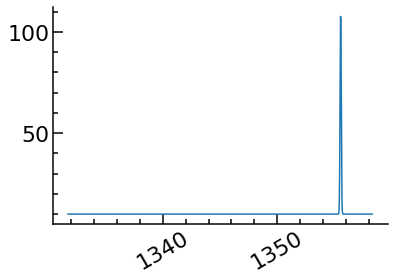

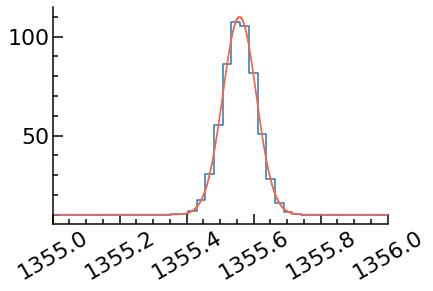

In [10]:
plt.plot(sg_oi_dict['wl'][:,0], test)
plt.tick_params(axis='x', labelrotation = 30)
plt.show()
plt.plot(sg_oi_dict['wl'][:,0], test, drawstyle ='steps-mid')
plt.plot(wavel_test, test2, drawstyle ='steps-mid', color = 'tomato')
plt.xlim([1355, 1356])
plt.tick_params(axis='x', labelrotation = 30)
plt.show()

> - Now, lets try to fit the output to recover the input

In [11]:
param, cov = curve_fit(gaussian_model, sg_oi_dict['wl'][:,0], test)

ValueError: Unable to determine number of fit parameters.

> - That didn't work. The error message tells us that it is due to curve_fit not being able to determine the number of parameters. If you recall, earlier we pass *p to our Gaussian function, meaning it can accept any number of variables. So, curve_fit needs to know how many we are actually wanting to search for. 
> - We can do this by passing a guess to curve_fit

In [12]:
guess = (75, 1355.2, 0.2, 10)
param, cov = curve_fit(gaussian_model, sg_oi_dict['wl'][:,0], test, p0 = guess)

> - You can see that the fit is not good

[ -12.07695537 1340.35282286   24.68151975   21.8005875 ]


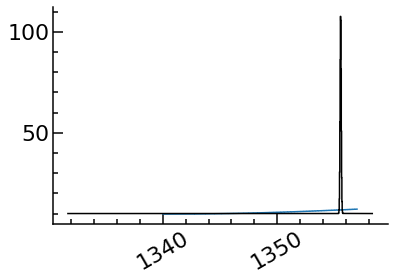

In [15]:
print(param)
### Lets set a new wavelength array that oversamples our line so we get a smooth 
### curve based on the fit results
wavel = np.arange(1340, 1357, 0.01)
plt.plot(wavel, gaussian_model(wavel, *param), drawstyle ='steps-mid')
plt.plot(sg_oi_dict['wl'][:,0], test, color = 'black', drawstyle ='steps-mid')
# plt.xlim([1355, 1356])
plt.tick_params(axis='x', labelrotation = 30)
plt.show()

> - If we set the initial guess of the centroid to be closer to the actual value what happens?

In [27]:
guess = (75, 1355.6, 0.2, 25)
param, cov= curve_fit(gaussian_model, sg_oi_dict['wl'][:,0], test, p0 = guess)

[1.00000000e+02 1.35555800e+03 4.99999999e-02 1.00000000e+01]


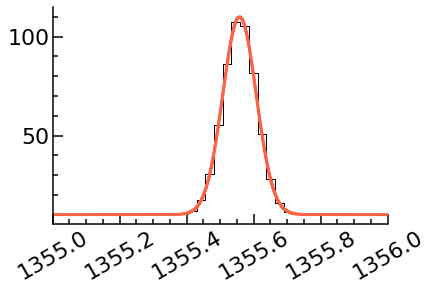

In [28]:
print(param)
### Lets set a new wavelength array that oversamples our line so we get a smooth 
### curve based on the fit results
wavel = np.arange(1354, 1357, 0.001)
plt.plot(sg_oi_dict['wl'][:,0], test, color = 'black', drawstyle = 'steps-mid', linewidth = 1)
plt.plot(wavel, gaussian_model(wavel, *param), 
         drawstyle ='steps-mid', color = 'tomato',
         linewidth = 3)
plt.xlim([1355, 1356])
plt.tick_params(axis='x', labelrotation = 30)
plt.show()

> - What if we use the original guess, but constrain the fit range to be closer to our area of interest?

[-2.40462650e+01  1.35516731e+03  1.43542316e-01  3.04886601e+01]


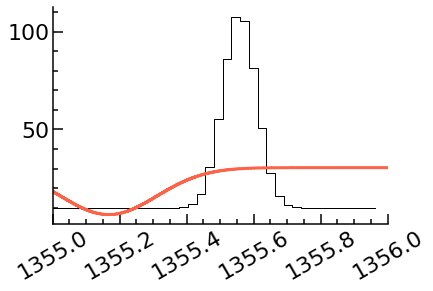

In [31]:
guess = (75, 1355.2, 0.1, 10)
wind1 = np.abs(sg_oi_dict['wl'][:,0] - 1355).argmin()
wind2 = np.abs(sg_oi_dict['wl'][:,0] - 1356).argmin()
plt.plot(sg_oi_dict['wl'][wind1:wind2,0], 
         test[wind1:wind2], 
         color = 'black', drawstyle = 'steps-mid', linewidth = 1)
param, cov= curve_fit(gaussian_model, 
                      sg_oi_dict['wl'][wind1:wind2,0], 
                      test[wind1:wind2], 
                      p0 = guess,
                      maxfev=100000,
                      xtol = 1.0e-5, ftol = 1.0e-5)

print(param)

wavel = np.arange(1354, 1357, 0.001)
plt.plot(wavel, gaussian_model(wavel, *param), 
         drawstyle ='steps-mid', color = 'tomato', 
         linewidth = 3)
plt.xlim([1355, 1356])
plt.tick_params(axis='x', labelrotation = 30)
plt.show()

> - Hmm, still not working! To be honest I am quite surprised it is not working. 
> - Lets try setting bounds on the model fits

[1.01959144e+00 1.35529734e+03 1.00123335e-02 2.26832740e+01]


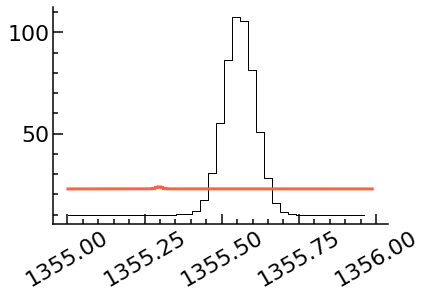

In [32]:
guess = (20, 1355.3, 0.05, 10)
bounds = ( (1,    1355, 0.01, 0), 
           (1000, 1357, 1,   50)
         )
wind1 = np.abs(sg_oi_dict['wl'][:,0] - 1355).argmin()
wind2 = np.abs(sg_oi_dict['wl'][:,0] - 1356).argmin()
plt.plot(sg_oi_dict['wl'][wind1:wind2,0], 
         test[wind1:wind2], 
         color = 'black', drawstyle = 'steps-mid', linewidth = 1)
param, cov= curve_fit(gaussian_model, 
                      sg_oi_dict['wl'][wind1:wind2,0], 
                      test[wind1:wind2], 
                      p0 = guess,
                      bounds = bounds,
                      sigma = None,
                      absolute_sigma = True,
                      maxfev=10000,
                      xtol = 1.0e-5, ftol = 1.0e-5)
print(param)
wavel = np.arange(sg_oi_dict['wl'][wind1,0], sg_oi_dict['wl'][wind2,0], 0.001)
plt.plot(wavel, gaussian_model(wavel, *param), 
         drawstyle ='steps-mid', color = 'tomato', 
         linewidth = 3)
# plt.xlim([1355, 1356])
plt.tick_params(axis='x', labelrotation = 30)
plt.show()

***Lets get careful with the guess and bounds***
> - Here we are setting the guess to be close to the data:<br>
    1) the amplitude is the peak - average of the two values at the edge of the window. This is a decent approximation to the amplitude = peak - continuum;<br>
    2) the centroid is set to the rest wavelength;<br>
    3) the width is set to the guess of 0.025A converted to standard deviation (the angstoms come in as X is in angstroms);<br>
    4) the continuum level is the mean of the values either side of the window.
> - Here we are setting the bounds to be:<br>
    1) the amplitude is allowed to range 0 to infinite;<br>
    2) the centroid is allowed to range rest_wave +/- 1 Angstrom;<br>
    3) the width is allowed to vary 5 times from the initial guess;<br>
    4) the continuum level is allowed to vary 0 to infinte.
> - Try changing the rest wavelength value to see what happens

[1.19242537e-03 1.35655676e+03 8.59665253e-06 1.07078311e+01]


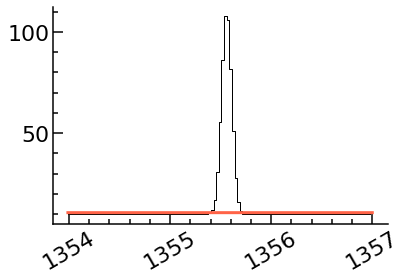

In [38]:
wind1 = np.abs(sg_oi_dict['wl'][:,0] - 1354).argmin()
wind2 = np.abs(sg_oi_dict['wl'][:,0] - 1357).argmin()

guess = (np.max(test[wind1:wind2]) - np.mean([test[wind1],test[wind2]]), 
         rest_wave+0.75, 
         widthguess/SIG2FWHM, 
         np.mean([test[wind1], test[wind2]]))
bounds = ( (0,      rest_wave-1, 0.0, 0) , 
           (np.inf, rest_wave+1, widthguess/SIG2FWHM*500, np.inf) )

plt.plot(sg_oi_dict['wl'][wind1:wind2,0], 
         test[wind1:wind2], 
         color = 'black', drawstyle = 'steps-mid', linewidth = 1)

param, cov= curve_fit(gaussian_model, 
                      sg_oi_dict['wl'][wind1:wind2,0], 
                      test[wind1:wind2], 
                      p0 = guess,
                      bounds = bounds,
                      sigma = np.sqrt(test[wind1:wind2]),
                      absolute_sigma = True,
                      maxfev=10000,
                      xtol = 1.0e-5, ftol = 1.0e-5)

print(param)
wavel = np.arange(sg_oi_dict['wl'][wind1,0], sg_oi_dict['wl'][wind2,0], 0.001)
plt.plot(wavel, gaussian_model(wavel, *param), 
         drawstyle ='steps-mid', color = 'tomato', 
         linewidth = 3)
# plt.xlim([1355, 1356])
plt.tick_params(axis='x', labelrotation = 30)
plt.show()

> - It is very temperamental with your choice of guess and bounds!
> - Here it isn't working probably because it is trying to fit the far wings of the continuum of our fake data.
> - Lets reduce the allowed range to be more focussed around our line.

[9.99999996e+01 1.35555800e+03 4.99999998e-02 1.00000001e+01]


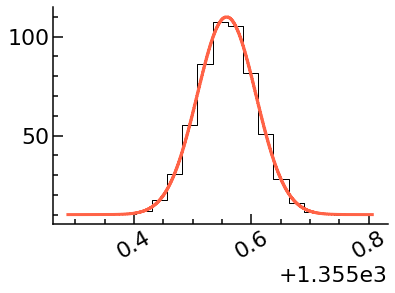

In [39]:
wind1 = np.abs(sg_oi_dict['wl'][:,0] - 1355.3).argmin()
wind2 = np.abs(sg_oi_dict['wl'][:,0] - 1355.8).argmin()

guess = (np.max(test[wind1:wind2]) - np.mean([test[wind1],test[wind2]]), 
         rest_wave+0.125, 
         widthguess/SIG2FWHM, 
         np.mean([test[wind1], test[wind2]]))
bounds = ( (0,      rest_wave-0.5, 0.0, 0) , 
           (1000, rest_wave+0.5, widthguess/SIG2FWHM*50, 1000) )

plt.plot(sg_oi_dict['wl'][wind1:wind2,0], 
         test[wind1:wind2], 
         color = 'black', drawstyle = 'steps-mid', linewidth = 1)

param, cov= curve_fit(gaussian_model, 
                      sg_oi_dict['wl'][wind1:wind2,0], 
                      test[wind1:wind2], 
                      p0 = guess,
                      bounds = bounds,
                      sigma = np.sqrt(test[wind1:wind2]),
                      absolute_sigma = True,
                      maxfev=10000,
                      xtol = 1.0e-5, ftol = 1.0e-5)

print(param)
wavel = np.arange(sg_oi_dict['wl'][wind1,0], sg_oi_dict['wl'][wind2,0], 0.001)
plt.plot(wavel, gaussian_model(wavel, *param), 
         drawstyle ='steps-mid', color = 'tomato', 
         linewidth = 3)
# plt.xlim([1355, 1356])
plt.tick_params(axis='x', labelrotation = 30)
plt.show()

---
### <b style="color:blue"> Now lets try with actual data </b>


In [42]:
0.50/rest_wave*3e5

110.65553816214431

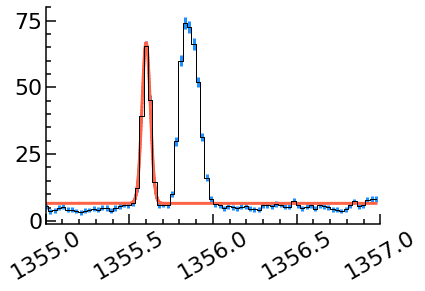

In [47]:
### Choose some data
wind1 = np.abs(sg_oi_dict['wl'][:,0] - 1355).argmin()
wind2 = np.abs(sg_oi_dict['wl'][:,0] - 1357).argmin()

data = copy.deepcopy(sg_oi_dict['data'][210,1369,wind1:wind2,0])
err = copy.deepcopy(sg_oi_dict_err['err_dn_s'][210,1369,wind1:wind2,0])
lamb = copy.deepcopy(sg_oi_dict['wl'][wind1:wind2,0])


guess = (np.max(data) - np.mean([data[0],data[-1]]), 
         rest_wave, 
         widthguess/SIG2FWHM,
         np.mean([data[0], data[-1]]))
bounds = ( (0,     rest_wave-0.50, 0.001, 0) , 
           (np.inf,  rest_wave+0.50, widthguess/SIG2FWHM*200, np.inf) )


plt.errorbar(lamb, data,
             xerr = 0, yerr = err,
             ecolor = 'dodgerblue',
             elinewidth = 3, 
             capsize = 0, capthick = 0, 
             errorevery = 1,
             drawstyle = 'steps-mid', linewidth = 1,
             color = 'black')
# plt.axvline(x=rest_wave, color = 'dodgerblue', linestyle = '--')

param, cov= curve_fit(gaussian_model, 
                      lamb, 
                      data, 
                      p0 = guess,
                      bounds = bounds,
                      sigma = err,
                      absolute_sigma = True,
                      maxfev=10000,
                      xtol = 1.0e-5, ftol = 1.0e-5)

wavel = np.arange(lamb[0], lamb[-1], 0.001)
plt.plot(wavel, gaussian_model(wavel, *param), 
         drawstyle ='steps-mid', color = 'tomato', 
         linewidth = 3)

plt.xlim([1355, 1357])
plt.tick_params(axis='x', labelrotation = 30)
plt.show()

> - That did an OK job(!), but you can see that the continuum level isn't great. 
> - That is, again, because we have the carbon line beside this. 
> - Although C I isn't really a Gaussian we can fit it with one, in order to try and capture the continuum properly.
> - It is also possible that the the C I and O I lines get close together, meaning it might be good to fit both simultaneously.
> - We can do that via fitting a Gaussian with multiple components and constraining those fairly tightly.

***A multi-component Gaussian model***
> - With that model we define as many Gaussians as we want.
> - Recall we have to define how many components in curve_fit via the p0 guess.

In [64]:
def gaussian_model_mult(x, *p):
    
    '''
    PURPOSE: To model a mutli-component Gaussian as a function of X
    
    INPUTS:  x -- float array
                  the values at which to evaluate the Gaussian(s)
             p -- tuple
                  p[0] is the amplitude of the Gaussian
                  p[1] is the centroid of the Gaussian
                  p[2] is the sigma (standard deviation) of the Gaussian 
                  ... the next three components are the same vars for the next Gaussian 
                  etc., 
                  p[-1] is some offset on the y-axis (i.e. the continuum level)
    
    OUTPUTS: y -- float array
                  The y-axis value associated with each input x-axis value x
                  
    NOTES: The model automatically works out how many components there are.
    
    '''   
    
    # work out number of Guassian comps 
    ncomp = int((len(p)-1)/3)
    
    # only necessary because of some issue I had making a tuple out of a list
    # of fit params from curve_fit.
    if ncomp == 0:
        p = p[0]
        ncomp = int((len(p)-1)/3)
    
    
    offset = p[-1]   
    
    cols = ['black', 'tomato', 'dodgerblue']
    
    # loop through each component and add to the running total
#     for i in range(ncomp):
#         A, mu, sigma = p[i*3:(i+1)*3]
#         testex = A * np.exp(-(x-mu)*(x-mu)/(2.0*sigma*sigma))
        
#         plt.plot(x, testex, color = cols[i], drawstyle = 'steps-mid')
#     plt.show()
    
    y = 0.0
    for i in range(ncomp):
        A, mu, sigma = p[i*3:(i+1)*3]
        y += A * np.exp(-(x-mu)*(x-mu)/(2.0*sigma*sigma))
        
#         plt.plot(x, y, color = cols[i], drawstyle = 'steps-mid')
#     plt.show()
        
    # the full result is each component + the background
    return y + offset 

In [65]:
pars_mult = tuple(([100, rest_wave, 0.05, 
               75, rest_wave+1, 0.1,
               150, rest_wave+1.25, 0.5,
               10]))
wind1 = np.abs(sg_oi_dict['wl'][:,0] - 1354).argmin()
wind2 = np.abs(sg_oi_dict['wl'][:,0] - 1359).argmin()
test_mult = gaussian_model_mult(sg_oi_dict['wl'][wind1:wind2,0], *pars_mult)
# wavel_test = np.arange(sg_oi_dict['wl'][0,0],sg_oi_dict['wl'][-1,0], 0.001)
# test2 = gaussian_model(wavel_test, *pars)

> - Try fitting that same pixel, but this time we include C I also

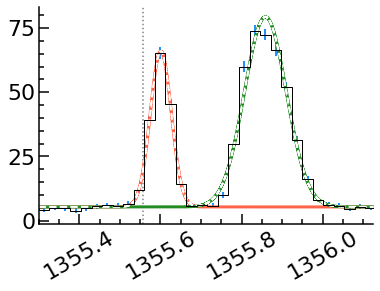

In [81]:

wind1 = np.abs(sg_oi_dict['wl'][:,0] - 1354.5).argmin()
wind2 = np.abs(sg_oi_dict['wl'][:,0] - 1357).argmin()

data = copy.deepcopy(sg_oi_dict['data'][210,1369,wind1:wind2,0])
err = copy.deepcopy(sg_oi_dict_err['err_dn_s'][210,1369,wind1:wind2,0])
lamb = copy.deepcopy(sg_oi_dict['wl'][wind1:wind2,0])


guess = (np.max(data) - np.mean([data[0],data[-1]]), rest_wave, widthguess/SIG2FWHM, ### GUESS FOR COMPONENT 1
         np.max(data) - np.mean([data[0],data[-1]]), 1355.7, widthguess/SIG2FWHM, ### GUESS FOR COMPONENT 2
         np.mean([data[0], data[-1]]))
bounds = ( (0, rest_wave-0.15, 0.001, 
            0, 1355.7-0.25, 0.001, 
            0) , 
           (1000,   rest_wave+0.15, widthguess/SIG2FWHM*200, 
            1000,   1355.7+0.25, widthguess/SIG2FWHM*200,   
             50) )


plt.errorbar(lamb, data,
             xerr = 0, yerr = err,
             ecolor = 'dodgerblue',
             elinewidth = 2, 
             capsize = 0, capthick = 0, 
             errorevery = 1,
             drawstyle = 'steps-mid', linewidth = 1,
             color = 'black')
plt.axvline(x=rest_wave, color = 'grey', linestyle = ':')


param, cov= curve_fit(gaussian_model_mult, 
                      lamb, 
                      data, 
                      p0 = guess,
                      bounds = bounds,
                      sigma = err,
                      absolute_sigma = True,
                      maxfev=10000,
                      xtol = 1.0e-5, ftol = 1.0e-5)

wavel = np.arange(lamb[0], lamb[-1], 0.001)

inds_set1 = [0, 1, 2, -1]
inds_set2 = [3, 4, 5, -1]

param_set1 = (param[inds_set1])
param_set2 = (param[inds_set2])

plt.plot(wavel, gaussian_model_mult(wavel, *param_set1), 
         drawstyle ='steps-mid', color = 'tomato', 
         linewidth = 3)
plt.plot(wavel, gaussian_model_mult(wavel, *param_set2), 
         drawstyle ='steps-mid', color = 'forestgreen', 
         linewidth = 3)
plt.plot(wavel, gaussian_model_mult(wavel, *param), 
         drawstyle ='steps-mid', color = 'white', 
         linewidth = 2, linestyle = '--')
# plt.axvline(x=1355.408, color = 'tomato', linestyle = '--')
# plt.axvline(x=1355.708, color = 'tomato', linestyle = '--')

plt.xlim([1355.3, 1356.125])
plt.tick_params(axis='x', labelrotation = 30)
plt.show()

> - That works a bit better!... and might be good to include both in case they merge together at some point